In [2]:
from pymongo import MongoClient
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
from sympy import degree
from tqdm.notebook import tqdm
import seaborn as sns
import powerlaw as plw
import datetime
from IPython.display import display, clear_output
import plotly.graph_objects as go
import igraph
from reddit import plotting, network
from reddit import datahandling as dh
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
client = MongoClient('localhost', 27017)
db = client.reddit

def getUTC(date):
    return date.replace(tzinfo=datetime.timezone.utc).timestamp()

In [4]:
def plotDegreedistr(G, axis, in_degree=False, out_degree=False, color='blue'):
    if in_degree:
        degr = np.array(G.in_degree())[:,1]
    elif out_degree:
        degr = np.array(G.out_degree())[:,1]
    else:
        degr = np.array(G.degree())[:,1]
    #alpha = plotting.plotpowerlaw(degr, axis, show_fit=True, discrete=False, xmin=1)
    plotting.plotlognormal(degr, axis, show_fit=True, color='blue', discrete=False, xmin=1)
    num_usrs = np.unique(edges[0]).shape[0]
    return 0, num_usrs


In [5]:
start = getUTC(datetime.datetime(2020,1,1))
end = getUTC(datetime.datetime(2020,2,1))
weird_subreddits = ['counting','DebateReligion','PurplePillDebate']#,'pan_media','MLPLounge','SVExchange','AskOuija','pokemontrades','changemyview','RoastMe']
colors = ['#a50026','#d73027','#f46d43','#fdae61','#fee090','#e0f3f8','#abd9e9','#74add1','#4575b4','#313695']
fig, axis = plt.subplots(1)
fig.set_figheight(4)
fig.set_figwidth(6)
fig.tight_layout()
for i,wsr in tqdm(enumerate(weird_subreddits)):
    data = dh.getData(db,wsr,start=start,end=end,col_name='comments', verbose=False)
    edges = (np.vstack((data['user_id'], data['parent_user_id'])))
    G = network.genNewNet(edges=edges)
    a, n = plotDegreedistr(G,axis, color=colors[i])
    a, n = plotDegreedistr(G,axis, in_degree=True, color=colors[i])
    a, n = plotDegreedistr(G,axis, out_degree=True, color=colors[i])

0it [00:00, ?it/s]

: 

: 

In [43]:
df=dh.getDataframe(db,'counting',start=start,end=end,col_name='comments')

author       object
id           object
parent_id    object
dtype: object


In [50]:
df.at[1,'parent_user_id'] = df.loc[1,'id']

In [47]:
print(df)

               author       id parent_id  user_id  parent_user_id
0          davidjl123  fconpbr   fconlmo      251              -1
1         mistyskye14  fcontsz   fconl0c      314             314
2       TheNitromeFan  fcontz6   fconpbr      184              -1
3         mistyskye14  fconudz   fconlan      314              -1
4       TheNitromeFan  fconv5t   fcontsz      184              -1
...               ...      ...       ...      ...             ...
142236        Bepkoyt  fg50bac   fg4mlcq       22              -1
142237        Bepkoyt  fg50bqb   fg4nfur       22              -1
142238   llamasR5life  fg50btq   fg4nyo3      307              -1
142239  ThreeDomeHome  fg50bva   fg50b6c      189              -1
142240    MrUnderdawg  fg50c81   fg50bva      121              -1

[142241 rows x 5 columns]


In [5]:
sdb = client.reddit_statistics
closestBelow = sdb.subreddit_submissions.find({'comments': {'$lte': 10000000}}).sort('comments',-1).limit(3)
cb = pd.DataFrame(list(closestBelow))
print(cb)

            _id  submissions  comments     score
0  Conservative       718158   9858017  53522498
1   Coronavirus       391428   9795013  87621467
2   Libertarian       495813   9711814  25671055


In [ ]:
fig, axis = plt.subplots(1)
fig.set_figheight(4)
fig.set_figwidth(6)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)
data = dh.getData(db,'politics',start=0,end=1,which='comments', save=False, verbose=True)
edges = (np.vstack((data[:,3], data[:,4])))
G = network.genNewNet(edges=edges)
a, n = plotDegreedistr(G,axis)
a, n = plotDegreedistr(G,axis, in_degree=True)
a, n = plotDegreedistr(G,axis, out_degree=True)
print(n)
print(nx.number_weakly_connected_components(G)/n)
axis.loglog()
axis.legend()

Try different Distributions 

In [39]:

data = dh.getData(db,'politics',col_name='politics', save=False, verbose=True)
#edges = (np.vstack((data[:,3], data[:,4])))
G = network.genNewNet(edges=edges)

Get dataframe from mongodb!


KeyError: 'id'

In [4]:
collection = db['politics']

In [8]:
df = pd.DataFrame(list(collection.find({'subreddit': 'politics'}, {'_id':0, 'created_utc':0, 'link_id':0, 'score':0}).limit(3000000)))
n = np.rint(collection.estimated_document_count()/3000000)
for i in tqdm(range(int(n+1))):
    df = pd.concat([df,pd.DataFrame(list(collection.find({'subreddit': 'politics'}, {'_id':0, 'created_utc':0, 'link_id':0, 'score':0}).skip((i+1)*3000000).limit(3000000)))])

 35%|███▌      | 19/54 [1:19:56<5:55:04, 608.70s/it]

In [5]:
collection = db['comments']
print(collection.find({'subreddit': 'politics'}))

In [14]:
df.drop(columns=['subreddit','score', 'link_id','_id','created_utc','num_comments','domain'], errors='ignore', inplace=True)

In [15]:
df['id'] = df['id'].astype('string') 
df['parent_id'] = df['parent_id'].astype('string').str.replace('t3_','')
df['parent_id'] = df['parent_id'].astype('string').str.replace('t1_','')

In [11]:
data = np.load('SubredditsData/Coronavirus.npy', allow_pickle=True)
data = data[data[:,4]!=351059]
data = data[data[:,0]!='[deleted]']

In [12]:
edges = (np.vstack((data[:,3], data[:,4])))
G = network.genNewNet(edges=edges)
G = igraph.Graph.from_networkx(G)

In [23]:
np.save('SubredditsData/Coronavirus.npy',data)

R and p Value for distribution comparison of pos lognorm and power law with xmin=1: R=177.303, p=0.000
R and p Value for distribution comparison of pos lognorm and power law with xmin=1: R=142.589, p=0.000
R and p Value for distribution comparison of pos lognorm and power law with xmin=1: R=51.654, p=0.000


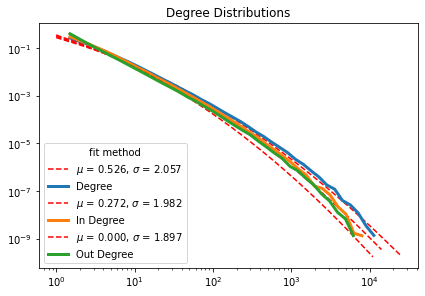

In [26]:
fig, axis = plt.subplots(1)
fig.set_figheight(4)
fig.set_figwidth(6)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)

degr = np.array(G.degree())
degr = degr[degr > 0]
xmin=1
fit = plw.Fit(degr, discrete=True, xmin=xmin, linear_bins=True)
R, p = fit.distribution_compare('lognormal_positive','power_law',normalized_ratio = True) #positive lognorm cause negative mean makes no sense
print('R and p Value for distribution comparison of pos lognorm and power law with xmin={}: R={:0.3f}, p={:0.3f}'.format(xmin,R,p))
#fit.power_law.plot_pdf(ax=axis, color = 'r', linestyle = '-')
str_label_fit = r'$\mu$ = {:0.3f}, $\sigma$ = {:0.3f}'.format(fit.lognormal_positive.mu, fit.lognormal_positive.sigma)
fit.lognormal_positive.plot_pdf(ax=axis, color='r', linestyle='--', **{'label': str_label_fit})
fit.plot_pdf(ax=axis, lw=3, original_data=True, **{'label': 'Degree'})

degr = np.array(G.degree(mode='in'))
degr = degr[degr > 0]

fit = plw.Fit(degr, discrete=True, xmin=xmin, linear_bins=True)
R, p = fit.distribution_compare('lognormal_positive','power_law',normalized_ratio = True) #positive lognorm cause negative mean makes no sense
print('R and p Value for distribution comparison of pos lognorm and power law with xmin={}: R={:0.3f}, p={:0.3f}'.format(xmin,R,p))
str_label_fit = r'$\mu$ = {:0.3f}, $\sigma$ = {:0.3f}'.format(fit.lognormal_positive.mu, fit.lognormal_positive.sigma)
fit.lognormal_positive.plot_pdf(ax=axis, color='r', linestyle='--', **{'label': str_label_fit})
fit.plot_pdf(ax=axis, lw=3, original_data=True, **{'label': 'In Degree'})

degr = np.array(G.degree(mode='out'))
degr = degr[degr > 0]
fit = plw.Fit(degr, discrete=True, xmin=xmin, linear_bins=True)
R, p = fit.distribution_compare('lognormal_positive','power_law',normalized_ratio = True) #positive lognorm cause negative mean makes no sense
print('R and p Value for distribution comparison of pos lognorm and power law with xmin={}: R={:0.3f}, p={:0.3f}'.format(xmin,R,p))
str_label_fit = r'$\mu$ = {:0.3f}, $\sigma$ = {:0.3f}'.format(fit.lognormal_positive.mu, fit.lognormal_positive.sigma)
fit.lognormal_positive.plot_pdf(ax=axis, color='r', linestyle='--', **{'label': str_label_fit})
fit.plot_pdf(ax=axis, lw=3, original_data=True, **{'label': 'Out Degree'})


axis.set_title('Degree Distributions')
#axis.set_xlabel('Node Degree')
axis.legend(title='fit method')

AttributeError: 'Graph' object has no attribute 'remove_nodes_from'

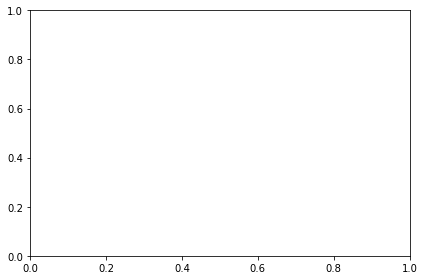

In [22]:
fig, axis = plt.subplots(1)
fig.set_figheight(4)
fig.set_figwidth(6)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)
G.remove_nodes_from(list(nx.isolates(G)))

degr = np.array(G.in_degree())[:,1]
data_nonzero = degr[degr > 0]
xmin=1
fit = plw.Fit(data_nonzero, discrete=True, xmin=xmin)
R, p = fit.distribution_compare('lognormal_positive','power_law',normalized_ratio = True) #positive lognorm cause negative mean makes no sense
print('R and p Value for distribution comparison of pos lognorm and power law with xmin={}: R={:0.3f}, p={:0.3f}'.format(xmin,R,p))
#fit.power_law.plot_pdf(ax=axis, color = 'r', linestyle = '-')
str_label_fit = r'$\mu$ = {:0.3f}, $\sigma$ = {:0.3f}'.format(fit.lognormal_positive.mu, fit.lognormal_positive.sigma)
fit.lognormal_positive.plot_pdf(ax=axis, color='r', linestyle='--', **{'label': str_label_fit})
fit.plot_pdf(ax=axis, lw=3, original_data=True, **{'label': 'In Degree'})

degr = np.array(G.out_degree())[:,1]
data_nonzero = degr[degr > 0]
fit = plw.Fit(data_nonzero, discrete=True, xmin=xmin)
str_label_fit = r'$\mu$ = {:0.3f}, $\sigma$ = {:0.3f}'.format(fit.lognormal_positive.mu, fit.lognormal_positive.sigma)
fit.lognormal_positive.plot_pdf(ax=axis, color='r', linestyle='--', **{'label': str_label_fit})
fit.plot_pdf(ax=axis, lw=3, original_data=True, **{'label': 'Out Degree'})

degr = np.array(G.degree())[:,1]
data_nonzero = degr[degr > 0]
fit = plw.Fit(data_nonzero, discrete=True, xmin=xmin)
str_label_fit = r'$\mu$ = {:0.3f}, $\sigma$ = {:0.3f}'.format(fit.lognormal_positive.mu, fit.lognormal_positive.sigma)
fit.lognormal_positive.plot_pdf(ax=axis, color='r', linestyle='--', **{'label': str_label_fit})
fit.plot_pdf(ax=axis, lw=3, original_data=True, **{'label': 'Degree'})


axis.set_title('Degree Distributions')
#axis.set_xlabel('Node Degree')
axis.legend(title='fit method')

Assuming nested distributions


R and p Value for distribution comparison of pos lognorm and power law with xmin=0.1: R=50.217, p=0.000


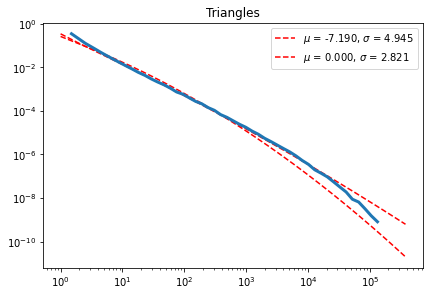

In [79]:
fig, axis = plt.subplots(1)
fig.set_figheight(4)
fig.set_figwidth(6)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)
"""undG = G.as_undirected()
np.seterr(divide='ignore', invalid='ignore')
triangles = np.array(get_triangles(undG))
triangles_nonzero = triangles[triangles>0]"""
xmin = 0.1
axis.set_title('Triangles')
fit = plw.Fit(triangles_nonzero, xmin=1,discrete=True, linear_bins=False)
R, p = fit.distribution_compare('lognormal','lognormal_positive',normalized_ratio = True) #positive lognorm cause negative mean makes no sense
print('R and p Value for distribution comparison of pos lognorm and power law with xmin={}: R={:0.3f}, p={:0.3f}'.format(xmin,R,p))

str_label_fit = r'$\mu$ = {:0.3f}, $\sigma$ = {:0.3f}'.format(fit.lognormal.mu, fit.lognormal.sigma)
fit.lognormal.plot_pdf(ax=axis, color='r', linestyle='--', **{'label': str_label_fit})
str_label_fit = r'$\mu$ = {:0.3f}, $\sigma$ = {:0.3f}'.format(fit.lognormal_positive.mu, fit.lognormal_positive.sigma)
fit.lognormal_positive.plot_pdf(ax=axis, color='r', linestyle='--', **{'label': str_label_fit})
fit.plot_pdf(ax=axis, lw=3, original_data=True)
axis.legend()

Assuming nested distributions


R and p Value for distribution comparison of pos lognorm and power law with xmin=0.1: R=178814.808, p=0.000


No valid fits found.


<AxesSubplot:title={'center':'Normalized Triangles'}>

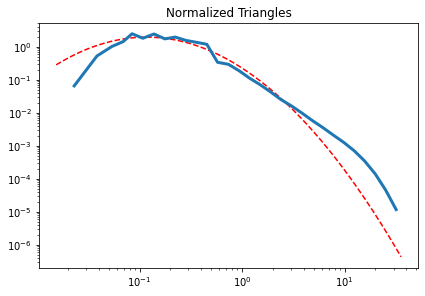

In [30]:
fig, axis = plt.subplots(1)
fig.set_figheight(4)
fig.set_figwidth(6)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)
"""undG = G.as_undirected()
np.seterr(divide='ignore', invalid='ignore')
triangles = np.array(get_triangles(undG))/np.array(undG.degree())
triangles = np.nan_to_num(triangles)
triangles_nonzero = triangles[triangles>0]"""
xmin = 0.1
axis.set_title('Normalized Triangles')
fit = plw.Fit(triangles_nonzero, xmin=0.01,discrete=False, linear_bins=True)
fit.lognormal.plot_pdf(ax=axis, color='r', linestyle='--', **{'label': 'Positive Lognormal'})

fit.plot_pdf(ax=axis, lw=3, original_data=True)

(687992,)


687992it [02:37, 4361.54it/s] 


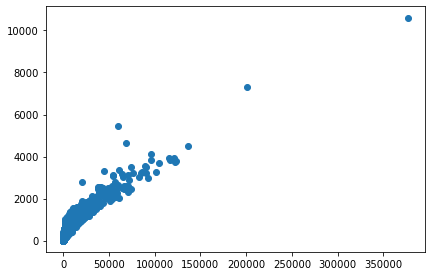

In [66]:
fig, axis = plt.subplots(1)
fig.set_figheight(4)
fig.set_figwidth(6)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)
undG = G.as_undirected()
axis.scatter(np.array(get_triangles(undG)),np.array(undG.degree()))

In [17]:
#undG = G.as_undirected()
print(data[np.where(data[:,3] == np.array(undG.degree()).argmax())])

[677063  30182 332526 620401]


In [21]:
a = [677063,30182,332526,620401]
for i in a:
    print(data[i,:])

['omgyoucunt' 'fjoiet5' 'fjoeo4x' 569862 338000]
['infinite_wanderings' 'ffymwb8' 'evw623' 487465 -1]
['carc' 'fivx036' 'fiuu2rv' 399458 129288]
['Unquietgirl' 'fjkry8l' 'fjkrld6' 328437 473117]


(687992,)
R and p Value for distribution comparison of pos lognorm and power law with xmin=0.1: R=111.637, p=0.000


No valid fits found.


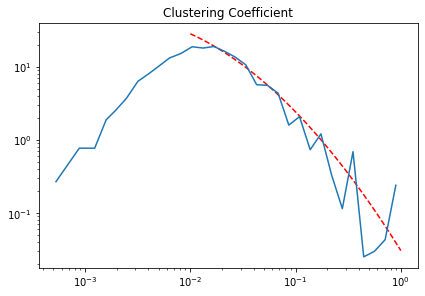

In [68]:

fig, axis = plt.subplots(1)
fig.set_figheight(4)
fig.set_figwidth(6)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)
undG = G.as_undirected()
np.seterr(divide='ignore', invalid='ignore')
clust = np.array(undG.transitivity_local_undirected())
print(clust.shape)
clust_nonzero = clust[clust>0]
axis.set_title('Clustering Coefficient')
fit = plw.Fit(clust_nonzero, xmin=0.01,discrete=False, linear_bins=True)
R, p = fit.distribution_compare('lognormal','power_law',normalized_ratio = True) #positive lognorm cause negative mean makes no sense
print('R and p Value for distribution comparison of pos lognorm and power law with xmin={}: R={:0.3f}, p={:0.3f}'.format(xmin,R,p))
str_label_fit = r'$\mu$ = {:0.3f}, $\sigma$ = {:0.3f}'.format(fit.lognormal_positive.mu, fit.lognormal_positive.sigma)
fit.lognormal.plot_pdf(ax=axis, color='r', linestyle='--', **{'label': str_label_fit})
fit.plot_pdf(ax=axis, original_data=True)
plt.savefig('Triangles.png')

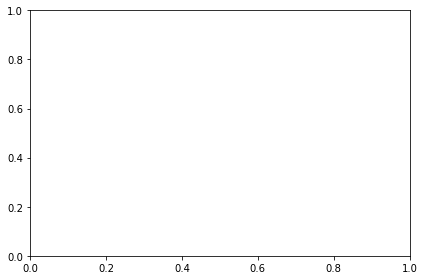

In [25]:
fig, axis = plt.subplots(1)
fig.set_figheight(4)
fig.set_figwidth(6)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)

In [40]:
print(undG.number_of_nodes())
print(undG.number_of_edges())
undG.remove_nodes_from(list(nx.isolates(undG)))
print(undG.number_of_nodes())
print(undG.number_of_edges())

691945
4093211
572788
4093211


Get dataframe from mongodb!


KeyboardInterrupt: 

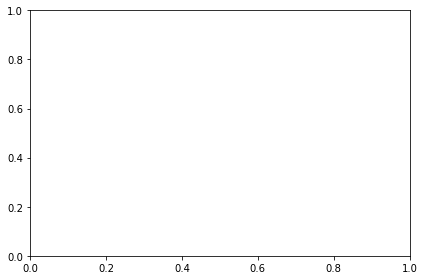

In [26]:
fig, axis = plt.subplots(1)
fig.set_figheight(4)
fig.set_figwidth(6)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)
data = dh.getData(db,'counting',start=0,end=1,which='comments', save=False, verbose=True)
edges = (np.vstack((data[:,3], data[:,4])))
G = network.genNewNet(edges=edges)
a, n = plotDegreedistr(G,axis)
a, n = plotDegreedistr(G,axis, in_degree=True)
a, n = plotDegreedistr(G,axis, out_degree=True)
print(nx.number_weakly_connected_components(G))
axis.loglog()
axis.legend()

R and p Value for distribution comparison of pos lognorm and power law with xmin=1: R=-64.177, p=0.000
R and p Value for distribution comparison of pos lognorm and power law with xmin=1: R=-28.954, p=0.000
R and p Value for distribution comparison of pos lognorm and power law with xmin=1: R=-59.542, p=0.000
R and p Value for distribution comparison of pos lognorm and power law with xmin=1: R=-67.065, p=0.000
R and p Value for distribution comparison of pos lognorm and power law with xmin=1: R=0.271, p=0.787
R and p Value for distribution comparison of pos lognorm and power law with xmin=1: R=-28.789, p=0.000
R and p Value for distribution comparison of pos lognorm and power law with xmin=1: R=-8.392, p=0.000
R and p Value for distribution comparison of pos lognorm and power law with xmin=1: R=-1.048, p=0.295
R and p Value for distribution comparison of pos lognorm and power law with xmin=1: R=-46.352, p=0.000
R and p Value for distribution comparison of pos lognorm and power law with x

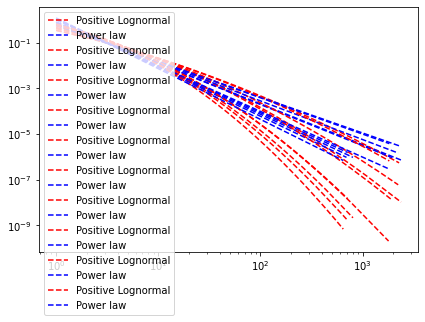

In [14]:
subreddits = dh.getTop(client.reddit_statistics, 10, 'comments')
fig, axis = plt.subplots(1)
fig.set_figheight(4)
fig.set_figwidth(6)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)
color = ['#f7fbff','#deebf7','#c6dbef','#9ecae1','#6baed6','#4292c6','#2171b5','#08519c','#08306b']
start = getUTC(datetime.datetime(2020,1,1))
end = getUTC(datetime.datetime(2020,1,14))
alpha = []
num_usrs = []
for idx, sr in enumerate(subreddits):
    if sr != ['distantsocializing'] and sr != ['RedditSessions']:
        data = dh.getData(db,sr.item(),start=start,end=end,which='comments', save=False)
        edges = (np.vstack((data[:,3], data[:,4])))
        G = network.genNewNet(edges=edges)
        degr = np.array(G.degree())[:,1]
        data_nonzero = degr[degr > 0]
        xmin=1
        fit = plw.Fit(data_nonzero, discrete=False, xmin=xmin, linear_bins=True)
        R, p = fit.distribution_compare('lognormal_positive','power_law') #positive lognorm cause negative mean makes no sense
        print('R and p Value for distribution comparison of pos lognorm and power law with xmin={}: R={:0.3f}, p={:0.3f}'.format(xmin,R,p))
        fit.lognormal_positive.plot_pdf(ax=axis, color='r', linestyle='--', **{'label': 'Positive Lognormal'})
        fit.power_law.plot_pdf(ax=axis, color='b', linestyle='--', **{'label': 'Power law'})

axis.loglog()
axis.legend()

Text(0.5, 1.0, 'Sorted Exponents Top 100 subreddits')

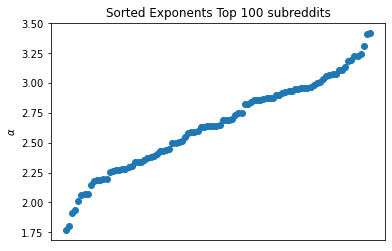

In [51]:
alpha_sorted = np.sort(alpha)
x = np.arange(np.shape(num_usrs)[0])
#plt.scatter(num_usrs,alpha)
#plt.scatter(dn, da, color='red')
plt.xticks([], [])
plt.scatter(x, alpha_sorted)
plt.ylabel(r'$\alpha$')
plt.title('Sorted Exponents Top 100 subreddits')
#plt.xscale('log')

2it [00:47, 23.65s/it]


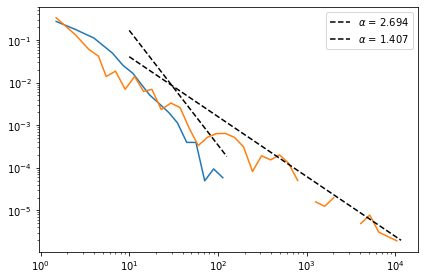

In [43]:
subreddits = dh.getTop(client.reddit_statistics, 1, 'comments')
subreddits = ['churning', 'counting']
fig, axis = plt.subplots(1)
fig.set_figheight(4)
fig.set_figwidth(6)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)
da = []
dn = []
color = ['#f7fbff','#deebf7','#c6dbef','#9ecae1','#6baed6','#4292c6','#2171b5','#08519c','#08306b']
start = getUTC(datetime.datetime(2020,1,1))
end = getUTC(datetime.datetime(2020,1,14))
for idx, sr in tqdm(enumerate(subreddits)):
    if sr != ['distantsocializing'] and sr != ['RedditSessions']:
        data = dh.getData(db,sr,start=start,end=end,which='comments', save=False)
        a, n = plotDegreedistr(data,axis)
        da.append(a)
        dn.append(n)

axis.loglog()
axis.legend()

## Different Timescales

[0.013946251805146059, 0.004387035765535681, 0.004615758768915231, 0.002099403150971675, 0.0026517621842498656, 0.0018918199412686642, 0.001905146489637321, 0.0010182892935025963, 0.0010317902535428743, 0.0010097782025479485, 0.0010668504321223093, 0.0011218763596885042, 0.001083251325721095, 0.0011001661373842922, 0.0008777191720704957, 0.0009085721825530018, 0.0009287192610410705, 0.0009584617582407792, 0.0008786734147284007, 0.0009117258699079569, 0.0007288820686382053, 0.0007059069847969805, 0.0006738954105923774, 0.000681569574396432, 0.0006659826890356762, 0.0006614033768977403, 0.0006550536272750173, 0.0006554115374658773, 0.0006594032413932895, 0.0006747388526964174, 0.0006752950393732874, 0.0006679075239860907, 0.0006755481206961878, 0.0006698046600194659, 0.0006846421324584015, 0.0006777531491643628, 0.0006810314096812035, 0.0006721306824458554, 0.000679698438043145, 0.0006753542505597359, 0.0006771760677450532, 0.0006743989008279078, 0.0006783580664390394, 0.0006782968302270

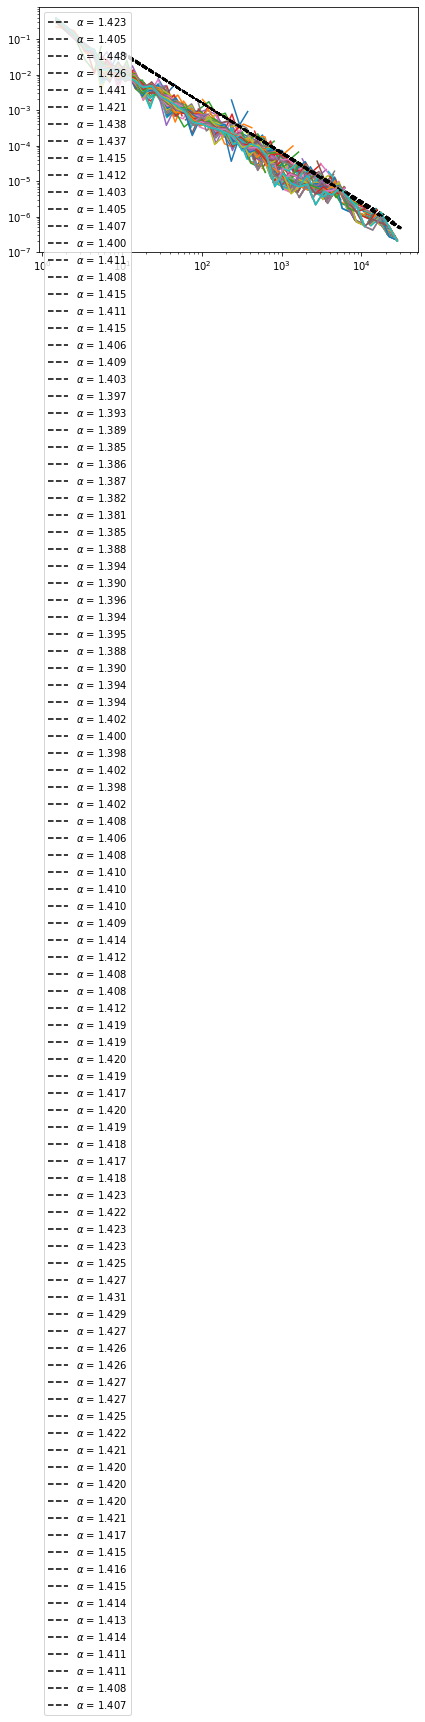

In [70]:
fig, axis = plt.subplots(1)
fig.set_figheight(4)
fig.set_figwidth(6)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)
color = ['#f7fbff','#deebf7','#c6dbef','#9ecae1','#6baed6','#4292c6','#2171b5','#08519c','#08306b']
start = getUTC(datetime.datetime(2020,1,1))
end = getUTC(datetime.datetime(2020,1,2))
alpha = []
num_usrs = []
cc = []
for i in range(100):
    data = dh.getData(db,'counting',start=start,end=end+i*86400 ,which='comments', save=False)
    edges = (np.vstack((data[:,3], data[:,4])))
    G = network.genNewNet(edges=edges)
    in_degr = np.array(G.in_degree())[:,1]
    a = plotting.plotpowerlaw(in_degr, axis, show_fit=True, discrete=False, xmin=10)
    n = np.unique(edges[0]).shape[0]
    M = nx.DiGraph()
    for u,v in G.edges():
        if M.has_edge(u,v):
            M[u][v]['weight'] += 1
        else:
            M.add_edge(u, v, weight=1)
    cc.append(nx.average_clustering(M,weight='weight'))
    alpha.append(a)
    display(fig)    
    clear_output(wait = True)
    num_usrs.append(n)
    print(cc)
    plt.pause(0.1)
display(fig)    
axis.loglog()
axis.legend()

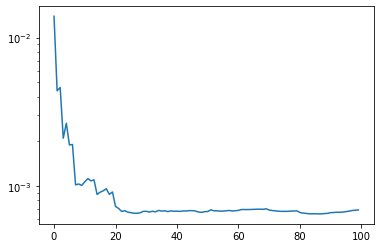

In [72]:
plt.plot(np.arange(np.shape(cc)[0]),cc)
plt.yscale('log')

In [1]:
plt.plot(np.arange(np.shape(alpha)[0]),alpha)

NameError: name 'plt' is not defined

In [68]:
pol_cc = cc

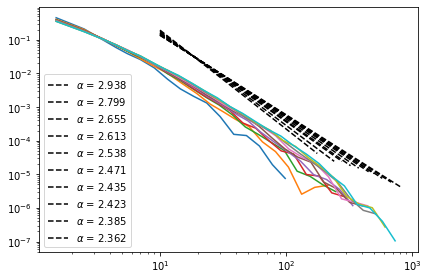

In [61]:
display(fig)    

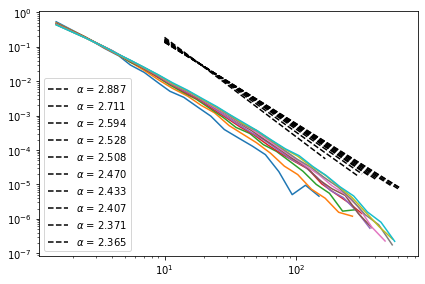

In [59]:
display(fig)    